In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from src import vrae, train, utils
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Feature col

In [2]:
batch_size = 64
time_size = 256
over_len = 128

# Load Data

In [3]:
folder_path = "/works/Data/wellysis/mit-bih-long-term-ecg-database-1.0.0/"
data_col = utils.data_from_mit(folder_path)

In [4]:
print("Data Name List : {}".format(list(data_col.keys())))

Data Name List : ['14046', '14134', '14149', '14157', '14172', '14184', '15814']


In [5]:
data_sample = utils.make_dataformat_from_mit(data_col=data_col, name='14046', time_len=time_size, over_len=over_len)

print(data_sample.shape, data_sample.max(), data_sample.min())

(84599, 256, 1) 1.0 0.0


# Make train set to tensor & Load Model

# VRAE with Normal Distribution Output Decoder & KL Term rate given

In [6]:
from src import vrae_normal_both

train_set = utils.tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

mod = vrae_normal_both.VRAE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

mod.build(input_shape=(batch_size,time_size,1))
mod.summary()

Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32
Model: "vrae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  16640     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  16640     
_________________________________________________________________
Encoding_MU_Dense (Dense)    multiple                  3870      
_________________________________________________________________
Encoding_STD_Dense (Dense)   multiple                  3870      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  3968      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  16640     
_________________________________________

In [7]:
# "/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs"
train_loss_results = vrae_normal_both.train(model=mod, train_dataset=train_set, epochs=100, learning_rate=0.0001,\
                                            summary_dir= "/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs",\
                                            add_name="_mit_2s_VRAE_128enc_30z_128dec_mseLikelihood_kldRate",\
                                            cp_dir="/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save")

EPOCH : 000 | ELBO : 0.778 | Reconstruct : 0.778 | KLD : 76.467 | MSE : 0.006079
EPOCH : 005 | ELBO : 0.157 | Reconstruct : 0.161 | KLD : 0.016 | MSE : 0.001256
EPOCH : 010 | ELBO : 0.143 | Reconstruct : 0.151 | KLD : 0.000 | MSE : 0.001179
EPOCH : 015 | ELBO : 0.138 | Reconstruct : 0.150 | KLD : 0.000 | MSE : 0.001169
EPOCH : 020 | ELBO : 0.134 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001167
EPOCH : 025 | ELBO : 0.131 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001166
EPOCH : 030 | ELBO : 0.127 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001165
EPOCH : 035 | ELBO : 0.123 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001164
EPOCH : 040 | ELBO : 0.119 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001164
EPOCH : 045 | ELBO : 0.115 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001163
EPOCH : 050 | ELBO : 0.112 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001164
EPOCH : 055 | ELBO : 0.108 | Reconstruct : 0.149 | KLD : 0.000 | MSE : 0.001163
EPOCH : 060 | ELBO : 0.104 | Reconstruc

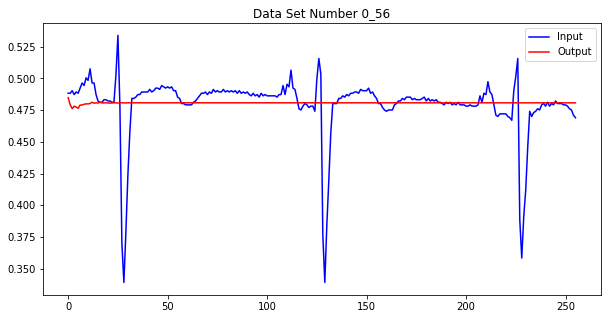

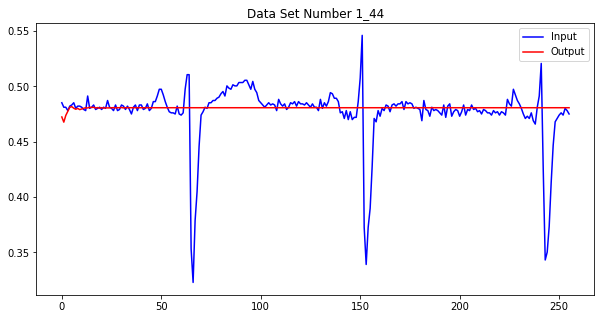

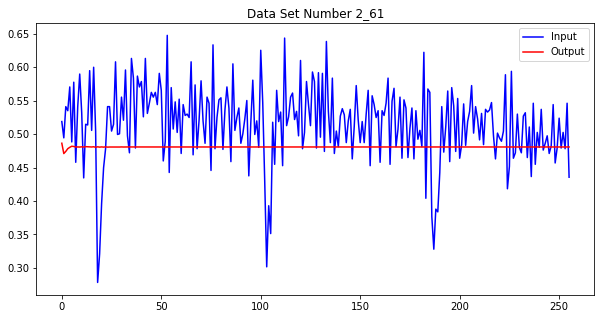

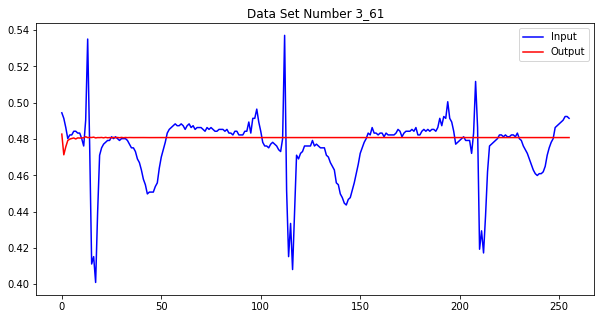

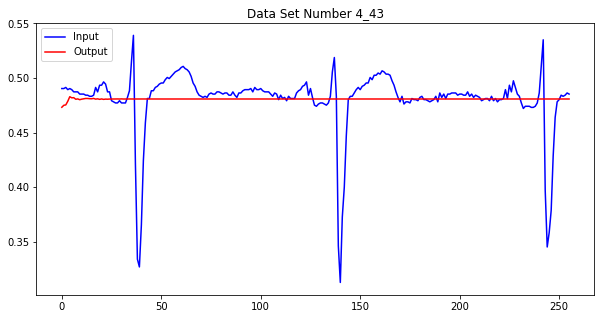

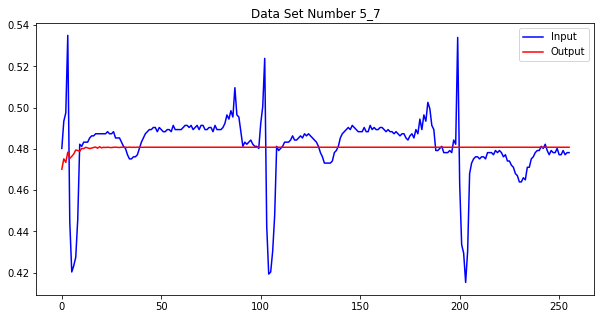

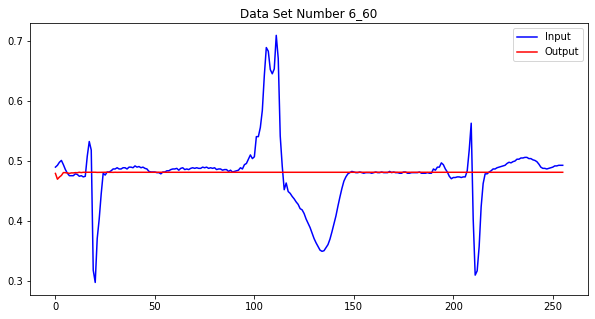

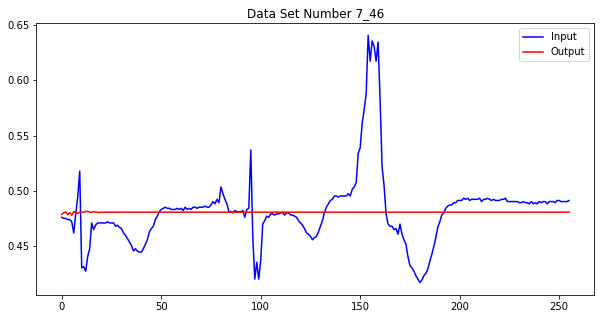

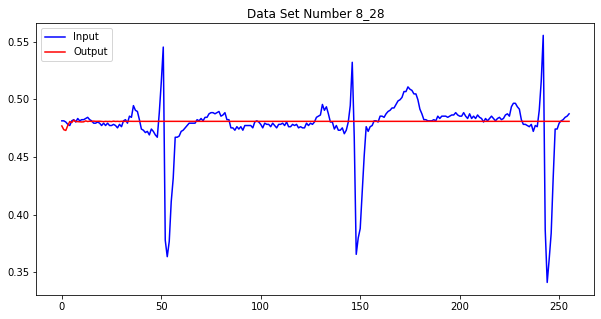

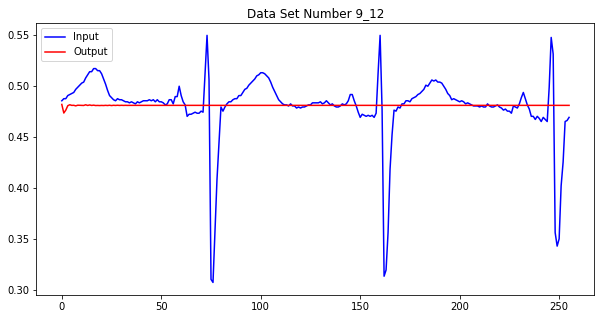

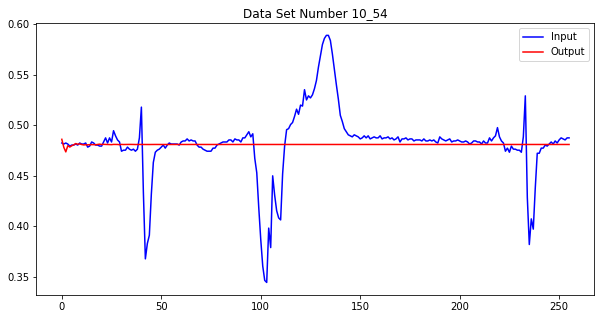

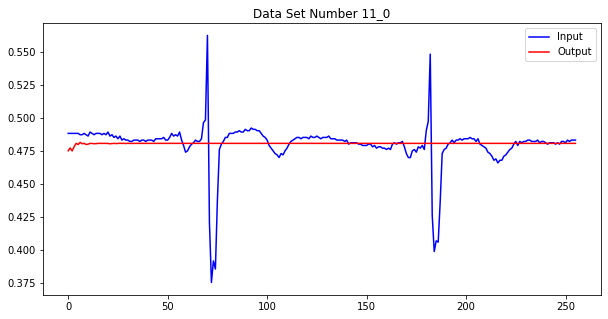

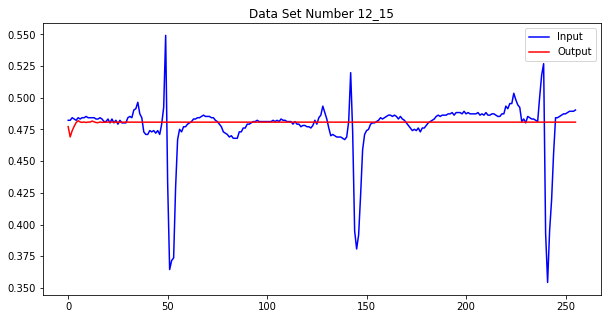

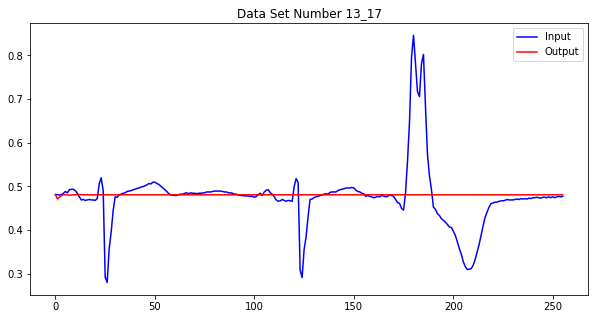

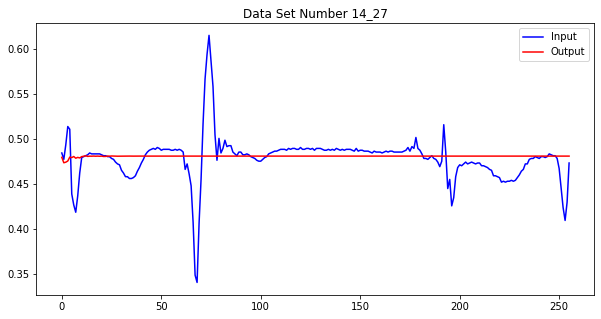

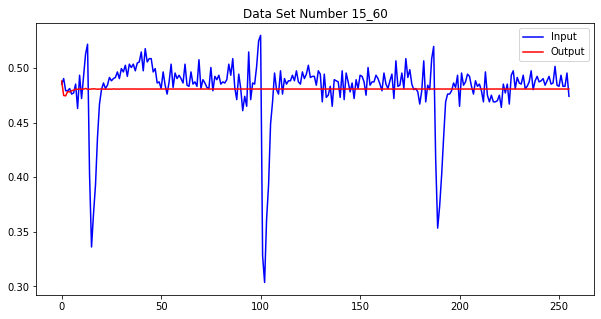

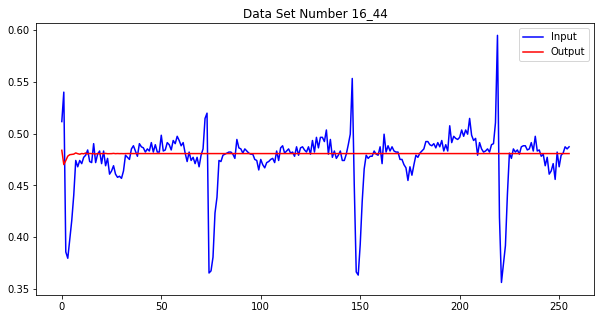

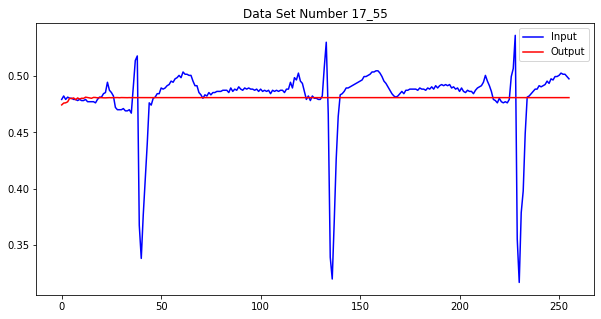

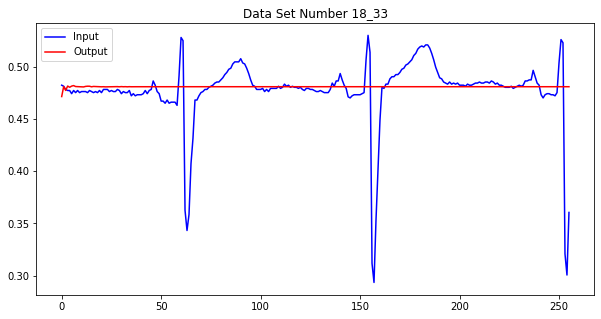

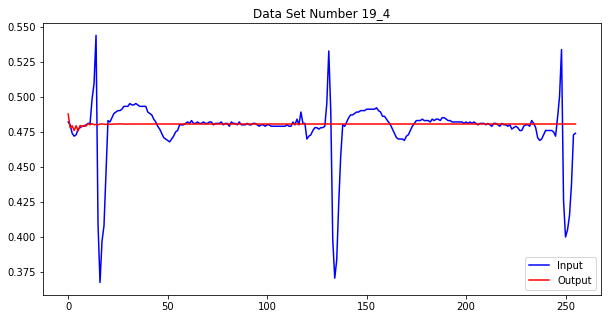

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 20
show_idx = 0

for x in train_set:
    output, _, _ = mod(x)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break